In [1]:
import numpy as np
import matplotlib as plt
import seaborn as sns
import matplotlib.colors
from Imitate import *
from Mimic import *
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import gaussian_kde

In [2]:
COLORS = {'SOIL': '#004488',
         'BBD': '#882255',
         'tr': '#BBBBBB',
         'imi': '#DDAA33',
         'bias': '#BB5566',
         'val': '#000000'}
COLNAMES = {'SOIL': 'blue', 'BBD': 'wine', 'imi': 'yellow'}
CMAPS = {'imi': matplotlib.colors.LinearSegmentedColormap.from_list("", [COLORS['imi'], 'white'], N=256),
        'SOIL': matplotlib.colors.LinearSegmentedColormap.from_list("", [COLORS['SOIL'], 'white'], N=256),
        'BBD': matplotlib.colors.LinearSegmentedColormap.from_list("", [COLORS['BBD'], 'white'], N=256),
        'bias_bi': matplotlib.colors.LinearSegmentedColormap.from_list("", ['white', COLORS['bias'], '#000000'], N=256),
        'SOIL_bi': matplotlib.colors.LinearSegmentedColormap.from_list("", ['#88CCEE', COLORS['SOIL'], '#000000'], N=256),
        'BBD_bi': matplotlib.colors.LinearSegmentedColormap.from_list("", ['#EE99AA', COLORS['BBD'], '#000000'], N=256)}

# Generator and Imitate Wrapper

In [3]:
# Generation of Cov:
# Cholesky decomposition: for every real-valued symmetric positive-definite (SPD) matrix M, there is a 
#   unique lower-diagonal matrix L with positive diagonal entries and LL^T = M
# => I generate lower-diagonal matrices m with positive diagonal and get Cov=mm^T !
def generatePills(num_instances, num_clusters, num_dims, return_params=False, seed=None, mean_low=1, mean_high=100):
    rng = np.random.default_rng(seed)
    points = np.empty((0,num_dims))
    labels = []
    params = []
    num_cl = ([num_instances // num_clusters + (1 if x < num_instances % num_clusters else 0)  for x in range (num_clusters)])
    for i in range(len(num_cl)):
        
        # generate Cov using Cholesky decomposition
        m = rng.integers(1,50)*(2*rng.random((num_dims, num_dims))-1)
        for j in range(len(m)):
            m[j,j] = np.abs(m[j,j])
        m = np.tril(m)
        cov = m.dot(m.transpose())
        
        # generate mean
        mean = rng.integers(mean_low,mean_high)*(2*rng.random(num_dims)-1)
        
        # sample points
        pts = rng.multivariate_normal(mean, cov, size=num_cl[i])
        
        points = np.concatenate((points, pts), axis=0)
        labels = np.append(labels, [i]*num_cl[i])
        params.append([mean, cov])
    if return_params: return points, np.array(labels), params
    return points, np.array(labels)


def generateBias(data, labels, num_biasedPills, prob=0.05, seed=None):
    rng = np.random.default_rng(seed)
    delete_this = []
    clusters = np.unique(labels)
    if num_biasedPills > len(clusters): num_biasedPills = len(clusters)
    
    # select blobs that will be biased
    bias_these = rng.choice(clusters, num_biasedPills, replace=False)
    alphas = rng.random(num_biasedPills) * 2*np.pi # angle for plane
    for blob, alpha in zip(bias_these, alphas):
        dims = rng.choice(range(len(data[0])), 2, replace=False)
        mean = data[labels == blob].mean(0)[dims]
        d = np.sqrt(np.sum((data[:,dims] - mean)**2, axis=1))
        angles = np.arcsin((data[:, dims[1]] - mean[1]) / d)
        angles = np.array([(np.pi - angles[i] if data[i, dims[0]] < mean[0] else angles[i]) for i in range(len(angles))])
        angles[angles < 0] += 2*np.pi
        if alpha >= np.pi:
            b = np.logical_or(angles > alpha, angles < alpha - np.pi)
        else:
            b = np.logical_and(angles > alpha, angles < (alpha + np.pi) % (2 * np.pi))
        b = np.logical_and(b, labels == blob)
        b = np.where(b)[0]
        b = np.delete(b, rng.choice(range(len(b)), int(prob*len(b)), replace=False))
        delete_this = np.append(delete_this, b)
        
    delete_this = delete_this.astype(int)
    d, l = np.delete(data, delete_this, axis=0), np.delete(labels, delete_this)
    return d, l, delete_this

In [4]:
class ImitateWrapper:
    
    def __init__(self):
        self.icas = {}
        self.grids = {}
        self.vals = {}
        self.fitted = {}
        self.fill_up = {}
        self.num_fill_up = {}
        
    def fit(self, data, labels, bounds={}, strength=1000):
        self.data = data
        self.labels = labels
        for l in np.unique(labels):
            d = data[labels == l]
            self.icas[l] = FastICA(n_components=len(data[0]))
            self.icas[l].fit(d)
            d_trf = self.icas[l].transform(d)
            b = bounds.get(l) if len(bounds)>0 else None
            self.grids[l], self.vals[l], self.fitted[l], self.fill_up[l], self.num_fill_up[l], _, _, _ = Imitate(
                d_trf, bounds=b, strength=strength)

    def augment(self):
        gen_points = np.empty((0, len(self.data[0])))
        gen_labels = []
        
        for l in np.unique(self.labels):
            num_fill_up = self.num_fill_up[l]
            num_gen = np.max(num_fill_up).astype(int)
            if num_gen == 0: continue
            grids, vals, fitted, fill_up = self.grids[l], self.vals[l], self.fitted[l], self.fill_up[l]
        
            points = np.empty((num_gen, 0))
            for d in range(len(self.data[0])):
                fill = fitted[d] / np.sum(fitted[d]) * (num_gen - num_fill_up[d])  +  fill_up[d] #mixed distr
                fill_cdf = np.cumsum(fill) / num_gen  #normalize

                #generate points according to the cdf
                vals = np.random.rand(num_gen)
                val_bins = np.searchsorted(fill_cdf, vals)
                coords = np.array([np.random.uniform(grids[d][val_bins[i]], grids[d][val_bins[i]+1]) 
                                   for i in range(num_gen)]).reshape(num_gen, 1)
                points = np.concatenate((points, coords), axis=1)

            gen_points = np.concatenate((gen_points, self.icas[l].inverse_transform(points)))
            gen_labels = np.append(gen_labels, [l]*num_gen)
        return gen_points, gen_labels

# IMITATE visualizations

In [5]:
X, y = generatePills(1000, 1, 2, return_params=False, seed=2003, mean_low=1, mean_high=100)
X_b, y_b, deleted_idcs = generateBias(X, y, 1, seed=2003)

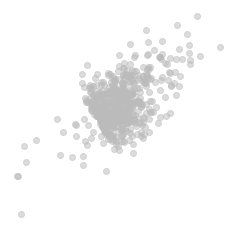

In [6]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
ax.scatter(X_b[:,0], X_b[:,1], c=COLORS['tr'], alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
#plt.savefig('Imi_B.pdf', bbox_inches='tight')
plt.show()

In [9]:
# train Imitate
imi = ImitateWrapper()
imi.fit(X_b, y_b)
gen_p, gen_l = imi.augment()

C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


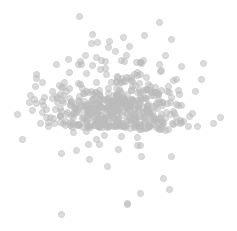

In [10]:
X_trf, p_trf = imi.icas[0].transform(X_b), imi.icas[0].transform(gen_p)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
ax.scatter(X_trf[:,0], X_trf[:,1], c=COLORS['tr'], alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
#plt.savefig('Imi_B_trf.pdf', bbox_inches='tight')
plt.show()

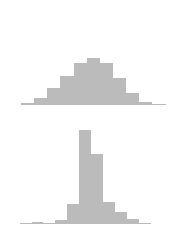

In [11]:
fig, ax = plt.subplots(2, 1, sharey=True, figsize=(3, 4))
xlims = [[-0.15, 0.15], [-0.25, 0.25]]
for d in range(2):
    mids = (np.array(imi.grids[0][d][:-1]) + np.array(imi.grids[0][d][1:])) / 2
    orig = imi.vals[0][d]
    ax[d].bar(mids, orig, width=(mids[1]-mids[0]), label='Original Data B', color=COLORS['tr'])
    #heights_gen = np.array([np.count_nonzero(np.digitize(p_trf[:,d], imi.grids[0][d]) == g) for g in range(len(mids))])
    #ax[d].bar(mids, heights_gen, bottom=orig, width=(mids[1]-mids[0]), label='Generated Points')
    #ax[d].bar(mids, imi.fitted[0][d]-orig, bottom=orig, width=(mids[1]-mids[0]), label='Generated Points', color=COLORS['imi'])
    #ax[d].plot(mids, imi.fitted[0][d], label='Fitted Gaussian', c=COLORS['BBD'])
    ax[d].set_xlim(xlims[d])
    ax[d].spines['top'].set_visible(False)
    ax[d].spines['right'].set_visible(False)
    ax[d].spines['bottom'].set_visible(False)
    ax[d].spines['left'].set_visible(False)
    ax[d].get_xaxis().set_ticks([])
    ax[d].get_yaxis().set_ticks([])
#plt.savefig('Imi_distr.pdf', bbox_inches='tight')
plt.show()

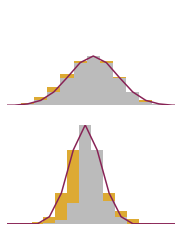

In [12]:
fig, ax = plt.subplots(2, 1, sharey=True, figsize=(3, 4))
xlims = [[-0.15, 0.15], [-0.25, 0.25]]
for d in range(2):
    mids = (np.array(imi.grids[0][d][:-1]) + np.array(imi.grids[0][d][1:])) / 2
    orig = imi.vals[0][d]
    ax[d].bar(mids, orig, width=(mids[1]-mids[0]), label='Original Data B', color=COLORS['tr'])
    #heights_gen = np.array([np.count_nonzero(np.digitize(p_trf[:,d], imi.grids[0][d]) == g) for g in range(len(mids))])
    #ax[d].bar(mids, heights_gen, bottom=orig, width=(mids[1]-mids[0]), label='Generated Points')
    ax[d].bar(mids, imi.fitted[0][d]-orig, bottom=orig, width=(mids[1]-mids[0]), label='Generated Points', color=COLORS['imi'])
    ax[d].plot(mids, imi.fitted[0][d], label='Fitted Gaussian', c=COLORS['BBD'])
    ax[d].set_xlim(xlims[d])
    ax[d].spines['top'].set_visible(False)
    ax[d].spines['right'].set_visible(False)
    ax[d].spines['bottom'].set_visible(False)
    ax[d].spines['left'].set_visible(False)
    ax[d].get_xaxis().set_ticks([])
    ax[d].get_yaxis().set_ticks([])
#plt.savefig('Imi_gaussian.pdf', bbox_inches='tight')
plt.show()

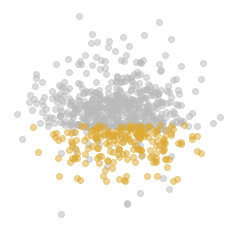

In [13]:
p_sub = p_trf[p_trf[:,1]<0]
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
ax.scatter(X_trf[:,0], X_trf[:,1], c=COLORS['tr'], alpha=0.5)
ax.scatter(p_sub[:,0], p_sub[:,1], c=COLORS['imi'], alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
#plt.savefig('Imi_gen.pdf', bbox_inches='tight')
plt.show()

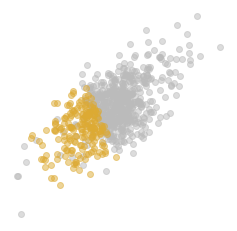

In [14]:
p_sub = imi.icas[0].inverse_transform(p_trf[p_trf[:,1]<0])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
ax.scatter(X_b[:,0], X_b[:,1], c=COLORS['tr'], alpha=0.5)
ax.scatter(p_sub[:,0], p_sub[:,1], c=COLORS['imi'], alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
#plt.savefig('Imi_final.pdf', bbox_inches='tight')
plt.show()

# CANCELS visualizations

In [15]:
soil_compounds = ['C1=CC(=CC(=C1)C(=NNC(=O)N[14C]2=[14CH][14CH]=[14C]([14CH]=[14CH]2)OC(F)(F)F)CC3=CC=C(C=C3)C#N)C(F)(F)F',
                 'CCC1=C(C(=CC=C1)C)N(COCC)C(=O)CS(=O)(=O)O',
                 '[14CH]1=[14CH][14C](=[14CH][14C](=[14CH]1)C(=NNC(=O)NC2=CC=C(C=C2)OC(F)(F)F)CC3=CC=C(C=C3)C#N)C(F)(F)F',
                 'CC1(C)C(=O)N(CC2=CC(=CC=C2Cl)O)OC1O',
                  'C(C(=O)O)N1C=NC=N1',
                  'C(C(=O)C(=O)O)N1C=NC=N1',
                  'CC1(C)[C@@H](/C=C(/Cl)\Cl)[C@@H]1C(=O)O',
                  'C[C@H]1CN(C[C@H](C)O1)C2CCCCCCCCCCC2',
                  'C(=S)(Cl)Cl',
                  'C1=NC(=O)NN1']

In [16]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

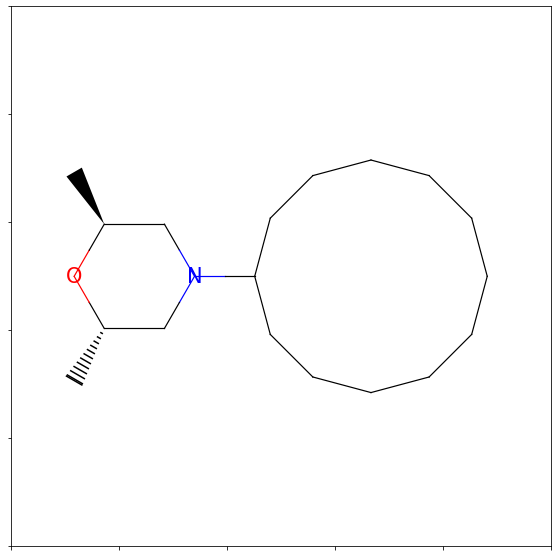

In [17]:
m = Chem.MolFromSmiles(soil_compounds[7])
fig = Draw.MolToMPL(m, size=(300,300))

#### PCA-Space

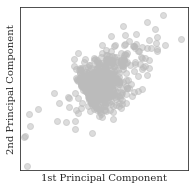

In [18]:
sns.set_style("ticks")
plt.rc('font', family='serif')
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
ax.scatter(X_b[:,0], X_b[:,1], c=COLORS['tr'], alpha=0.5)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_xlim([-100, 100])
ax.set_ylim([-200, 200])
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
#plt.savefig('NewAlgo_PCA.pdf', bbox_inches='tight')
plt.show()

#### Imitate

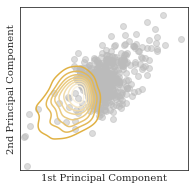

In [19]:
sns.set_style("ticks")
plt.rc('font', family='serif')
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
ax.scatter(X_b[:,0], X_b[:,1], c=COLORS['tr'], alpha=0.5)
sns.kdeplot(x=gen_p[:,0], y=gen_p[:,1], cmap=CMAPS['imi'], cut=10, thresh=0)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_xlim([-100, 100])
ax.set_ylim([-200, 200])
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
#plt.savefig('NewAlgo_Imi.pdf', bbox_inches='tight')
plt.show()

#### Ground-Truth Space

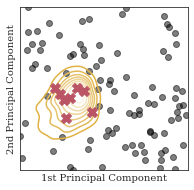

In [20]:
gt = np.random.uniform(low=[-100, -200], high=[100, 200], size=(100, 2))
kde = gaussian_kde(gen_p.T)
sel = gt[kde(gt.T) >= 0.00005]

sns.set_style("ticks")
plt.rc('font', family='serif')
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
ax.scatter(gt[:,0], gt[:,1], c=COLORS['val'], alpha=0.5)
sns.kdeplot(x=gen_p[:,0], y=gen_p[:,1], cmap=CMAPS['imi'], cut=10, thresh=0, zorder=2)
ax.scatter(sel[:,0], sel[:,1], c=COLORS['bias'], marker='X', zorder=3, s=100)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_xlim([-100, 100])
ax.set_ylim([-200, 200])
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
#plt.savefig('NewAlgo_GT.pdf', bbox_inches='tight')
plt.show()

# Why Imitate is different from EM

In [8]:
data = np.random.normal(0, 3, 5000)
data_b = data[data<1.7]
gm1_params = norm.fit(data_b.reshape(-1, 1))
grids, vals, fitted, fill_up, num_fill_up, scale, mean, cov = Imitate(data_b.reshape(-1, 1))

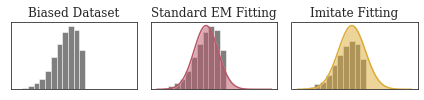

In [9]:
sns.set_style("ticks")
plt.rc('font', family='serif')
bins = 20

fig = plt.figure(figsize=(6, 1.5))
grid = fig.add_gridspec(ncols=3, nrows=1)
gt = fig.add_subplot(grid[0, 0], xticklabels=[], yticklabels=[], xticks=[], yticks=[])
gm1 = fig.add_subplot(grid[0, 1], xticklabels=[], yticklabels=[], xticks=[], yticks=[])
imi = fig.add_subplot(grid[0, 2], xticklabels=[], yticklabels=[], xticks=[], yticks=[])

gt.set_title('Biased Dataset')
gm1.set_title('Standard EM Fitting')
imi.set_title('Imitate Fitting')

x = np.linspace(-10, 10, 100)

c_gt = 1
gt.hist(data_b, bins=bins, range=[-10,10], density=True, alpha=0.5, color=COLORS['val'])
    
#y = norm(mean, np.sqrt(cov[0,0])).pdf(x)*1.25 #(len(data)/len(data_b))*(scale[0]/5000)
y = norm(mean, np.sqrt(cov[0,0])).pdf(x)*scale[0]
imi.hist(data_b, bins=bins, range=[-10,10], density=False, alpha=0.5, color=COLORS['val'])
imi.plot(x, y, c=COLORS['imi'])
imi.fill_between(x, 0, y, alpha=0.5, facecolor=COLORS['imi'])

y = norm(gm1_params[0], gm1_params[1]).pdf(x)#*len(data_b)
c_gm1 = 3
gm1.hist(data_b, bins=bins, range=[-10,10], density=True, alpha=0.5, color=COLORS['val'])
gm1.plot(x, y, c=COLORS['bias'])
gm1.fill_between(x, 0, y, alpha=0.5, facecolor=COLORS['bias'])

plt.tight_layout()
plt.savefig('Plots/Imitate_vs_EM.pdf', bbox_inches='tight')
plt.show()

# Bounded Imitate: Weight Impact

In [10]:
X, y = generatePills(1000, 4, 2, seed=5555)
d = X[:,1]

In [11]:
num_bins = 20
d_range = (min(d) - 0.5*(max(d)-min(d)), max(d) + 0.5*(max(d)-min(d)))
grid = [(d_range[0] + i*((d_range[1] - d_range[0]) / num_bins)) for i in range(num_bins+1)]
mids = np.array(grid[:-1] + np.diff(grid)/2)
kde = KDEUnivariate(d)
kde.fit(bw='silverman', kernel='gau', fft=False)
values = np.array([kde.evaluate(i)[0] if kde.evaluate(i) > 0 else 0 for i in mids])
values_scaled = (len(d) / sum(values)) * values

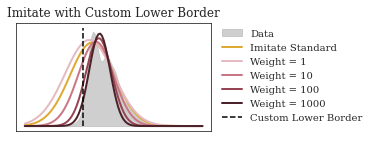

In [17]:
border = -100
x = np.linspace(grid[0], grid[-1], 100)
lw = 2

sns.set_style("ticks")
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize = (3.5, 2))

ax.fill_between(x, 0, (len(d) / sum(values)) * kde.evaluate(x), color=COLORS['tr'], label='Data', alpha=0.7)
fitted, p = scaled_norm_bounded(ends_zero=True, ends_zero_strength=1).fit(mids, values_scaled, d, returnParams=True)
ax.plot(x, norm(p[1], p[2]).pdf(x)*p[0], label='Imitate Standard', c=COLORS['imi'], lw=lw)
fitted, p = scaled_norm_bounded(ends_zero=True, ends_zero_strength=1, bound_min=border).fit(mids, values_scaled, d, returnParams=True)
ax.plot(x, norm(p[1], p[2]).pdf(x)*p[0], label='Weight = 1', c=CMAPS['bias_bi'](int(1*256/5)), lw=lw)
fitted, p = scaled_norm_bounded(ends_zero=True, ends_zero_strength=10, bound_min=border).fit(mids, values_scaled, d, returnParams=True)
ax.plot(x, norm(p[1], p[2]).pdf(x)*p[0], label='Weight = 10', c=CMAPS['bias_bi'](int(2*256/5)), lw=lw)
fitted, p = scaled_norm_bounded(ends_zero=True, ends_zero_strength=100, bound_min=border).fit(mids, values_scaled, d, returnParams=True)
ax.plot(x, norm(p[1], p[2]).pdf(x)*p[0], label='Weight = 100', c=CMAPS['bias_bi'](int(3*256/5)), lw=lw)
fitted, p = scaled_norm_bounded(ends_zero=True, ends_zero_strength=1000, bound_min=border).fit(mids, values_scaled, d, returnParams=True)
ax.plot(x, norm(p[1], p[2]).pdf(x)*p[0], label='Weight = 1000', c=CMAPS['bias_bi'](int(4*256/5)), lw=lw)
ax.set_title('Imitate with Custom Lower Border')
ax.vlines(border, -1, 300, linestyles='dashed', label='Custom Lower Border', color=COLORS['val'])
plt.xticks([], [])
plt.yticks([], [])
plt.legend(loc='lower left', bbox_to_anchor=(1.01, 0), ncol=1, frameon=False)
plt.savefig('Plots/Imitate_customBorder.pdf', bbox_inches='tight')